In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score  
from scipy.spatial.distance import correlation
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise import Dataset, Reader, accuracy
from sklearn import metrics
from collections import Counter
from sklearn.metrics import roc_curve, auc

In [389]:
df = pd.read_csv("/Users/ryan/Downloads/Synthetic_Movie_Lens/ratings.csv")
ratings_matrix = pd.pivot_table(df, values="rating", columns=["movieId"], index=["userId"])

# QUESTION 1: Explore the Dataset:

In [3]:
print(len(df.userId.unique()))

610


In [4]:
print(len(df.movieId.unique()))

9724


### A. Compute the sparsity of the movie rating dataset:

In [383]:
user_ID = df.pop('userId').values
movie_ID = df.pop('movieId').values
Rating = df.pop('rating').values
sparsity = len(Rating)/(len(set(movie_ID))*len(set(user_ID)))

print('%.10f'%sparsity)

0.0169996831


### B Plot a histogram showing the frequency of the rating values: Bin the raw rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R that fall within each bin and use this count as the height of the vertical axis for that particular bin. Comment on the shape of the histogram.

Text(0, 0.5, 'frequency of ratings')

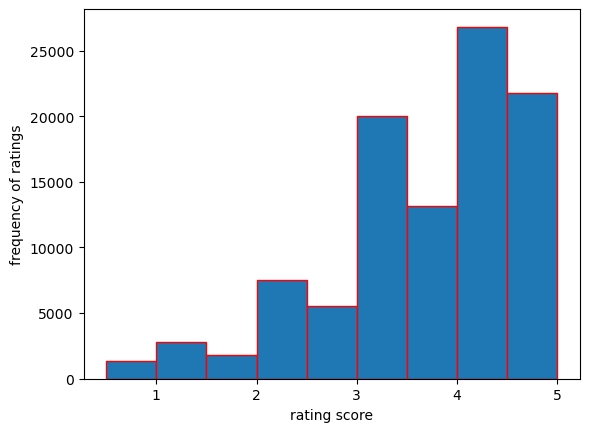

In [8]:
binwidth=0.5
plt.hist(df["rating"],bins = np.arange(min(df.rating), max(df.rating) + binwidth,step = binwidth),edgecolor='red')

plt.xlabel('rating score')
plt.ylabel('frequency of ratings')

### C Plot the distribution of the number of ratings received among movies: The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend is expected.

<AxesSubplot:xlabel='movieId'>

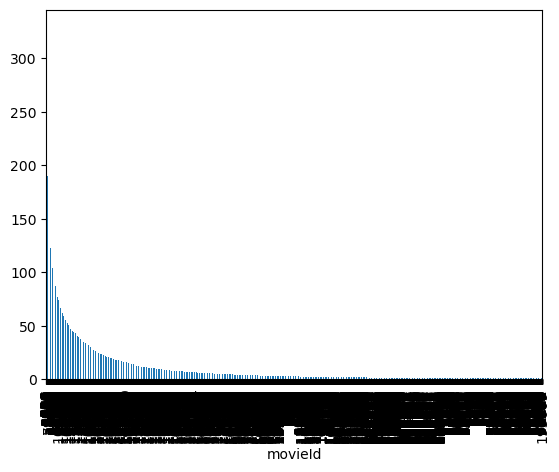

In [9]:
movie_count = df.groupby('movieId').size().sort_values(ascending=False)
movie_count.plot(kind='bar',y='number of ratings movie recieved',x='Id')

### D Plot the distribution of ratings among users: The X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user has rated. The requirement of the plot is similar to that in Question C.

<AxesSubplot:xlabel='userId'>

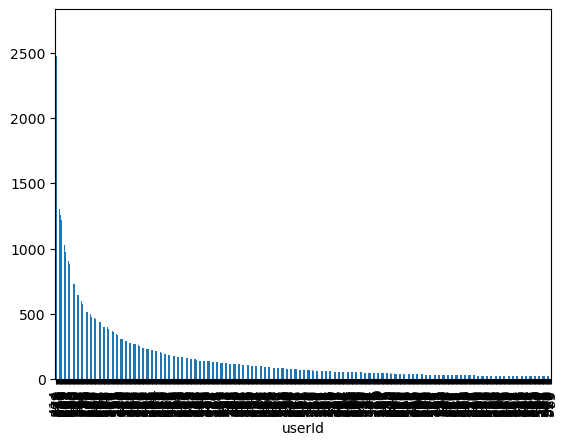

In [10]:
user_count = df.groupby('userId').size().sort_values(ascending=False)
user_count.plot(kind='bar',y='number of movies rated',x='UserId')

### E Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.
### A: Some movies has recieved many ratings and many user has rated many movies. This means that the movie that recieved many ratings and the users that rated many movies may be important to the recommendation system. And may be we can waive the movies that has little ratings.

### F Compute the variance of the rating values received by each movie: Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the resulting histogram

Text(0, 0.5, 'frequency of rating score variance')

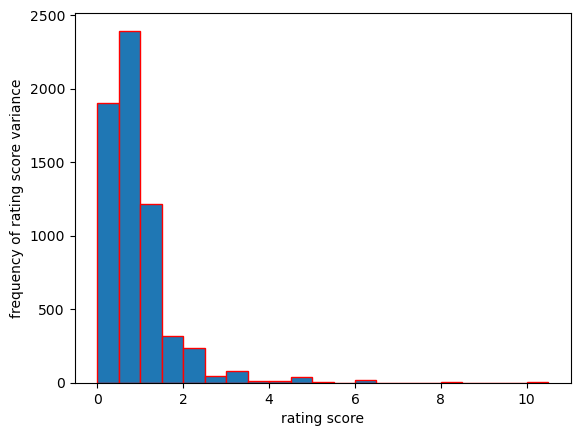

In [11]:
var_movie = df.groupby('movieId').var()
binwidth=0.5
plt.hist(var_movie["rating"],bins = np.arange(min(var_movie.rating), max(var_movie.rating) + binwidth,step = binwidth),edgecolor='red')

plt.xlabel('rating score')
plt.ylabel('frequency of rating score variance')

# QUESTION 2: Understanding the Pearson Correlation Coefficient:
### A Write down the formula for $\mu_u$ in terms of $\ I_u$ and $r_{u k}$;
$\mu_u=\frac{\sum r_{u k}}{\sum I_u}$
### B In plain words, explain the meaning of Iu ∩Iv. Can Iu ∩Iv = ∅? (Hint: Rating matrix R is sparse)
The meaning of  Iu ∩ Iv is that the set of items that both user u and v both rated, it can be zero.

# QUESTION 4: 
Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis)

In [15]:
from surprise import Reader
from surprise import Dataset

reader = Reader(rating_scale=(0.5, 5))
rating = Dataset.load_from_df(df[['userId','movieId','rating']], reader)

In [20]:
RMSE = []
MAE = []

for i in range(2,102,2):
   result = cross_validate(KNNWithMeans(k=i, sim_options={'name':'pearson'},verbose=False), data=rating, measures=['RMSE', 'MAE'],cv=10)
   RMSE.append(np.mean(result['test_rmse']))
   MAE.append(np.mean(result['test_mae']))

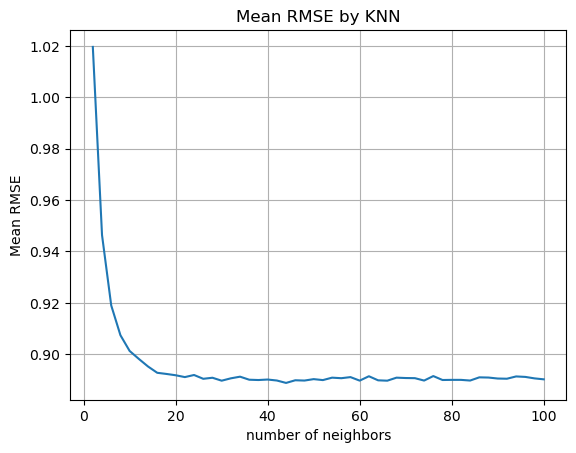

In [22]:
KNNrange = np.arange(2, 102, 2)
fig, ax = plt.subplots()
ax.plot(KNNrange, RMSE)

ax.set(xlabel='number of neighbors', ylabel='Mean RMSE',
       title='Mean RMSE by KNN')
ax.grid()


plt.show()

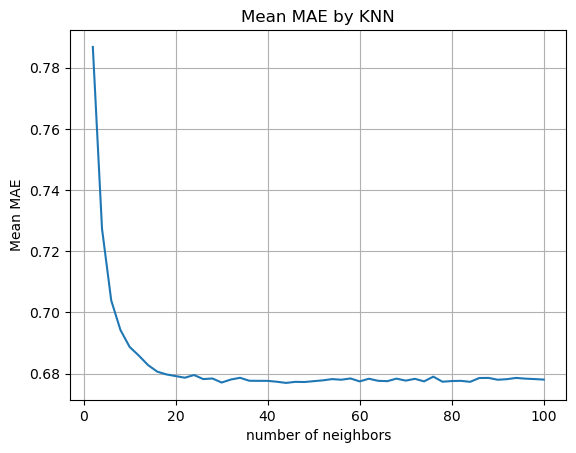

In [23]:

fig, ax = plt.subplots()
ax.plot(KNNrange, MAE)

ax.set(xlabel='number of neighbors', ylabel='Mean MAE',
       title='Mean MAE by KNN')
ax.grid()


plt.show()

# QUESTION 5:
Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum
k’ in this context means that increasing k above the minimum value would not result in a significant
decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would
correspond to the k value for which average RMSE and average MAE converges to a steady-state
value. Please report the steady state values of average RMSE and average MAE.
### A: From the graph above,  we can observe that both average MAE and RMSE converge when K = 20

In [29]:
print("Mean RMSE at K = 20 : ",RMSE[10])
print("Mean MAE at K = 20 : " ,MAE[10] )

Mean RMSE at K = 20 :  0.8910846957698014
Mean MAE at K = 20 :  0.6786256724713728


# QUESTION 6: 
Within EACH of the 3 trimmed subsets in the dataset, design (train and
validate):
A k-NN collaborative filter on the ratings of the movies (i.e Popular, Unpopular or High-Variance)
and evaluate each of the three models’ performance using 10-fold cross validation:

## Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

### Popular movie trimming


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

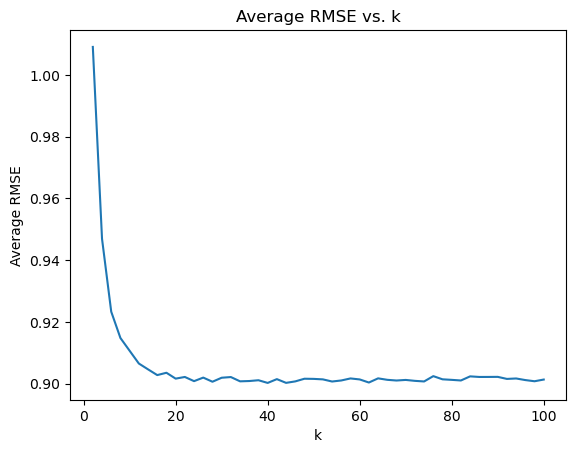

Minimum average RMSE: 0.9002 (k = 40)


In [56]:
movie_ratings = df.groupby('movieId').size()
data_df = df[df['movieId'].isin(movie_ratings.index[movie_ratings >= 3])]

# Select the required columns
data_df = data_df[['userId', 'movieId', 'rating']]

# Define the rating scale
reader = Reader(rating_scale=(0.5, 5))

# Load the data from the dataframe
data = Dataset.load_from_df(data_df, reader)
# Define the range of k values to sweep
k_values = range(2, 101, 2)

# Compute the average RMSE for each k using 10-fold cross-validation
avg_rmse_list = []
for k in k_values:
    sim_options = {'name': 'pearson', 'user_based': True}
    algo = KNNWithMeans(k=k, sim_options=sim_options)
    results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse = np.mean(results['test_rmse'])
    avg_rmse_list.append(avg_rmse)

# Plot the average RMSE against k
plt.plot(k_values, avg_rmse_list)
plt.title('Average RMSE vs. k')
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.show()

# Find the minimum average RMSE and corresponding k value
min_avg_rmse = min(avg_rmse_list)
min_k = k_values[avg_rmse_list.index(min_avg_rmse)]
print(f'Minimum average RMSE: {min_avg_rmse:.4f} (k = {min_k})')

### Unpopular movie trimming

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

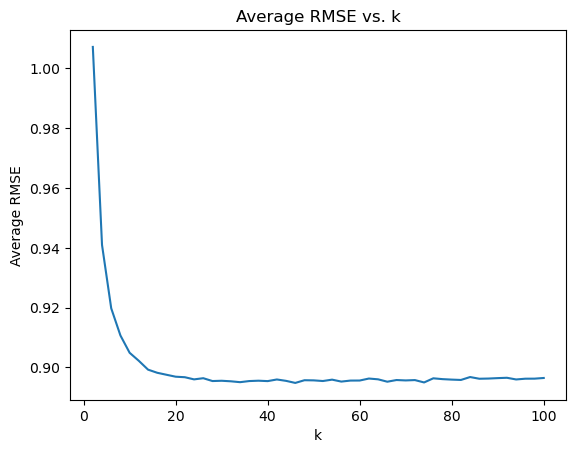

Minimum average RMSE: 0.8948 (k = 46)


In [61]:

# Unpopular movie trimming
# Load data into Surprise dataset
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Unpopular movie trimming
min_movie_ratings = 3
filter_movies = df['movieId'].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

# Apply the filter
df = df[df['movieId'].isin(filter_movies)]

# Load trimmed data into Surprise dataset
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
# Define the range of k values to sweep
k_values = range(2, 101, 2)

# Compute the average RMSE for each k using 10-fold cross-validation
avg_rmse_list = []
for k in k_values:
    sim_options = {'name': 'pearson', 'user_based': True}
    algo = KNNWithMeans(k=k, sim_options=sim_options)
    results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse = np.mean(results['test_rmse'])
    avg_rmse_list.append(avg_rmse)

# Plot the average RMSE against k
plt.plot(k_values, avg_rmse_list)
plt.title('Average RMSE vs. k')
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.show()

# Find the minimum average RMSE and corresponding k value
min_avg_rmse = min(avg_rmse_list)
min_k = k_values[avg_rmse_list.index(min_avg_rmse)]
print(f'Minimum average RMSE: {min_avg_rmse:.4f} (k = {min_k})')

### High variance trimming

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

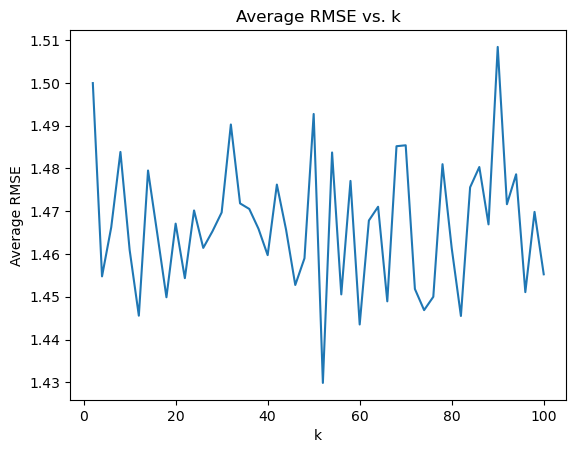

Minimum average RMSE: 1.4299 (k = 52)


In [60]:
# Load data from CSV and select only relevant columns
data_df = df[['userId', 'movieId', 'rating']]

# Count the number of ratings per movie
movie_counts = data_df['movieId'].value_counts()

# Compute the variance of ratings for each movie
movie_variances = data_df.groupby('movieId')['rating'].var()

# Trim the dataset to contain only movies with at least 5 ratings and variance >= 2
movie_ids_to_keep = movie_counts[(movie_counts >= 5) & (movie_variances >= 2)].index
trimmed_df = data_df[data_df['movieId'].isin(movie_ids_to_keep)]

# Load data into Surprise Dataset object
reader = Reader()
data = Dataset.load_from_df(trimmed_df, reader)
# Compute the average RMSE for each k using 10-fold cross-validation
avg_rmse_list = []
for k in k_values:
    sim_options = {'name': 'pearson', 'user_based': True}
    algo = KNNWithMeans(k=k, sim_options=sim_options)
    results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse = np.mean(results['test_rmse'])
    avg_rmse_list.append(avg_rmse)

# Plot the average RMSE against k
plt.plot(k_values, avg_rmse_list)
plt.title('Average RMSE vs. k')
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.show()

# Find the minimum average RMSE and corresponding k value
min_avg_rmse = min(avg_rmse_list)
min_k = k_values[avg_rmse_list.index(min_avg_rmse)]
print(f'Minimum average RMSE: {min_avg_rmse:.4f} (k = {min_k})')

### Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5,3,3.5,4]. These thresholds are applied only on the ground truth labels in held-out validation set. For each of the plots, also report the area under the curve (AUC) value. You should have 4 ×4 plots in this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds can be condensed into one plot per trimming option yielding only 4 plots.

In [283]:
def popular_trim(testset: List[Tuple[int, int, float]]) -> List[Tuple[int, int, float]]:
    # Count the number of ratings for each movie
    movie_ratings = defaultdict(int)
    for (uid, iid, rating) in testset:
        movie_ratings[iid] += 1

    # Identify popular movies
    popular_movies = set(iid for iid, count in movie_ratings.items() if count > 2)

    # Filter out unpopular movies from the test set
    return [t for t in testset if t[1] in popular_movies]
    
def unpopular_trim(testset: List[Tuple[int, int, float]]) -> List[Tuple[int, int, float]]:
    # Count the number of ratings for each movie
    movie_ratings = defaultdict(int)
    for (uid, iid, rating) in testset:
        movie_ratings[iid] += 1

    # Identify unpopular movies
    unpopular_movies = set(iid for iid, count in movie_ratings.items() if count <= 2)

    # Filter out popular movies from the test set
    return [t for t in testset if t[1] in unpopular_movies]


def high_var_trim(testset: List[Tuple[int, int, float]]) -> List[Tuple[int, int, float]]:
    # Group ratings by movie
    movie_ratings = defaultdict(list)
    for (uid, iid, rating) in testset:
        movie_ratings[iid].append(rating)

    # Identify high variance movies
    high_variance_movies = set(iid for iid, ratings in movie_ratings.items()
                                if len(ratings) >= 5 and np.var(ratings) >= 2)

    # Filter out low variance movies from the test set
    return [t for t in testset if t[1] in high_variance_movies]





Computing the pearson similarity matrix...
Done computing similarity matrix.
Results for No Trimming with k=20


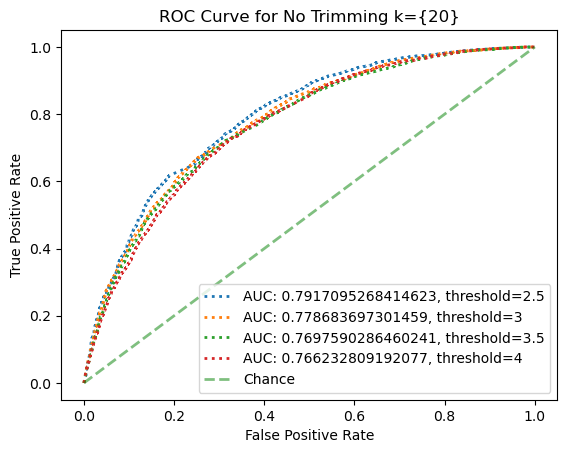

In [275]:

# Load the data

reader = Reader(rating_scale=(0.5, 5.0))


# Define the k-NN collaborative filtering algorithm and train the models

thresholds = [2.5, 3, 3.5, 4]

data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)
algo = KNNWithMeans(k=20, sim_options={'name': 'pearson', 'user_based': True})
res = algo.fit(trainset).test(testset)
print("Results for No Trimming with k=20")
fig, ax = plt.subplots()
for item in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for No Trimming k={20}')
plt.legend(loc="lower right")
plt.show()

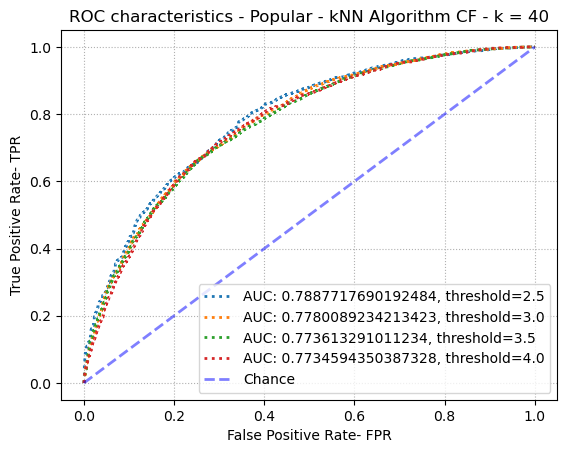

In [272]:
from typing import List, Tuple
from collections import defaultdict

def popular_movie_trimming(testset: List[Tuple[int, int, float]]) -> List[Tuple[int, int, float]]:
    # Count the number of ratings for each movie
    movie_ratings = defaultdict(int)
    for (uid, iid, rating) in testset:
        movie_ratings[iid] += 1

    # Identify popular movies
    popular_movies = set(iid for iid, count in movie_ratings.items() if count > 2)

    # Filter out unpopular movies from the test set
    return [t for t in testset if t[1] in popular_movies]
reader = Reader(rating_scale=(0.5, 5.0))
Dataset_Ratings= Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)



# Define the k-NN collaborative filtering algorithm and train the models

thresholds = [2.5, 3, 3.5, 4]


k = 40
Train_list, Test_list = train_test_split(Dataset_Ratings, test_size=0.1)
Thres_list = [2.5, 3.0, 3.5, 4.0]

Pop_Trimmed_set = popular_movie_trimming(Test_list)
res  = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(Train_list).test(Pop_Trimmed_set)

fig, ax = plt.subplots()
for item in Thres_list:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    FPR, TPR, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(FPR, TPR,lw=2,linestyle=':',label="AUC: "+str(auc(FPR,TPR))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)  
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics - Popular - kNN Algorithm CF - k = 40')
plt.ylabel('True Positive Rate- TPR')
plt.xlabel('False Positive Rate- FPR')
plt.savefig('Q6a.png',dpi=350,bbox_inches='tight')
plt.show() 

Computing the pearson similarity matrix...
Done computing similarity matrix.
Results for unpopular trimming'} with k=46


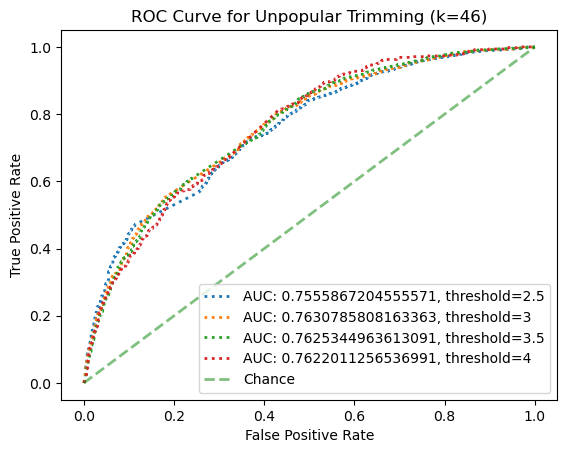

In [277]:
#unpopular trimmming

thresholds = [2.5, 3, 3.5, 4]

data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)
algo = KNNWithMeans(k=46, sim_options={'name': 'pearson', 'user_based': True})
res = algo.fit(trainset).test(unpopular_trim(testset))
print("Results for unpopular trimming'} with k=46")
fig, ax = plt.subplots()
for item in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Unpopular Trimming (k=46)')
plt.legend(loc="lower right")
plt.show()

Computing the pearson similarity matrix...
Done computing similarity matrix.
Results for high vairiance trimming'} with k=52


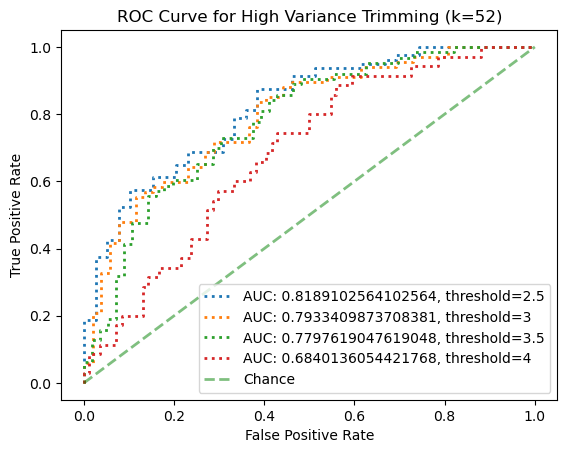

In [280]:
#high variance
thresholds = [2.5, 3, 3.5, 4]
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)
algo = KNNWithMeans(k=52, sim_options={'name': 'pearson', 'user_based': True})
res = algo.fit(trainset).test(high_var_trim(testset))
print("Results for high vairiance trimming'} with k=52")
fig, ax = plt.subplots()
for item in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for High Variance Trimming (k=52)')
plt.legend(loc="lower right")
plt.show()

# QUESTION 7: 
Understanding the NMF cost function: Is the optimization problem given by
equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate
it as a least-squares problem

### Convexity of Optimization Problem and Least-Squares Formulation

### A:
The optimization problem denoted by the equation is not jointly convex with respect to the variables U and V because it is a non-convex optimization problem.

The objective function is a sum of convex functions, each of the form $(r_{ij} - (UV^T)_{ij})^2$, which are convex in either U or V when the other is fixed. However, the product of two convex functions is not necessarily convex. In this case, the product $UV^T$ is a bilinear function of the variables U and V, which is not a convex function.

Therefore, the objective function is a non-convex function of both U and V, and the optimization problem is not jointly convex.

# Question 8 Designing the NMF Collaborative Filter:


### A 
Design a NMF-based collaborative filter to predict the ratings of the movies in the original
dataset and evaluate its performance using 10-fold cross-validation. Sweep k (number of
latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and
average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes
too long, you can increase the step size. Increasing it too much will result in poorer granularity
in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-
axis) against k (X-axis). For solving this question, use the default value for the regularization
parameter.


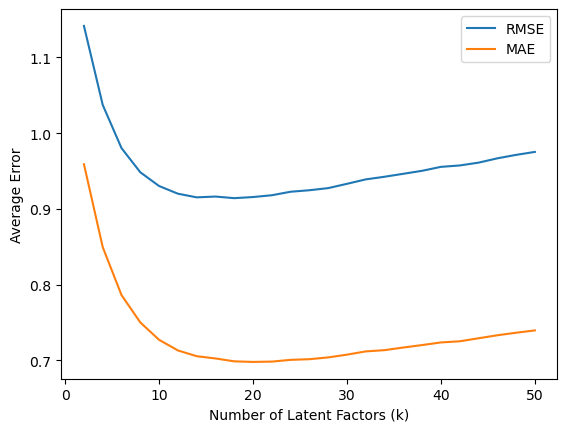

In [163]:
from surprise import NMF, Dataset, Reader
from surprise.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt

# load the dataset
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# define the range of k values to test
k_values = np.arange(2, 51, 2)

# perform 10-fold cross-validation with NMF algorithm
rmse_scores = []
mae_scores = []
for k in k_values:
    nmf = NMF(n_factors=k)
    results = cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    rmse_scores.append(np.mean(results['test_rmse']))
    mae_scores.append(np.mean(results['test_mae']))

# plot the results
plt.plot(k_values, rmse_scores, label='RMSE')
plt.plot(k_values, mae_scores, label='MAE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average Error')
plt.legend()
plt.show()



### B 
Use the plot from the previous part to find the optimal number of latent factors. Optimal
number of latent factors is the value of k that gives the minimum average RMSE or the
minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal
number of latent factors same as the number of movie genres?

### A: The optimal number of latent factors is 18 for RSME and 20 for MAE, which is really precise to the number of movie genres.

In [184]:
# find the optimal number of latent factors (k)
min_rmse = np.min(rmse_scores)
min_mae = np.min(mae_scores)
optimal_k_rmse = k_values[np.argmin(rmse_scores)]
optimal_k_mae = k_values[np.argmin(mae_scores)]
print('Optimal Number of Latent Factors (RMSE):', optimal_k_rmse)
print('Minimum Average RMSE:', min_rmse)
print('Optimal Number of Latent Factors (MAE):', optimal_k_mae)
print('Minimum Average MAE:', min_mae)

# count genre numbers
df_movie = pd.read_csv('/Users/ryan/Downloads/Synthetic_Movie_Lens/movies.csv');
df_movie['genres']

arr_of_genres = []
for i in df_movie['genres']:
  for j in i.split('|'):
    if j not in arr_of_genres:
      arr_of_genres.append(j)

print(arr_of_genres)
print(len(arr_of_genres))


Optimal Number of Latent Factors (RMSE): 18
Minimum Average RMSE: 0.9142137631676837
Optimal Number of Latent Factors (MAE): 20
Minimum Average MAE: 0.6980593351220484
['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'Film-Noir', '(no genres listed)']
20


### C
Performance on trimmed dataset subsets: For each of Popular, Unpopular and High-
Variance subsets -
– Design a NMF collaborative filter for each trimmed subset and evaluate its performance
using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step
sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE
across all 10 folds.
### – Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.


Evaluating RMSE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1450  1.1278  1.1451  1.1271  1.1332  1.1368  1.1491  1.1384  1.1447  1.1563  1.1403  0.0089  
Fit time          1.41    1.52    1.49    1.12    1.12    1.13    1.07    1.07    1.06    1.05    1.20    0.18    
Test time         0.27    0.26    0.28    0.25    0.23    0.28    0.25    0.24    0.24    0.25    0.25    0.02    
Evaluating RMSE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1438  1.1490  1.1406  1.1449  1.1314  1.1473  1.1444  1.1515  1.1369  1.1436  1.1433  0.0056  
Fit time          1.07    1.17    1.08    1.07    1.08    1.12    1.28    1.06    1.07    1.08    1.11    0.07    
Test time         0.24    0.25    0.24    0.24    0.24    0.24    0.24    0.25    0.23    0.24 

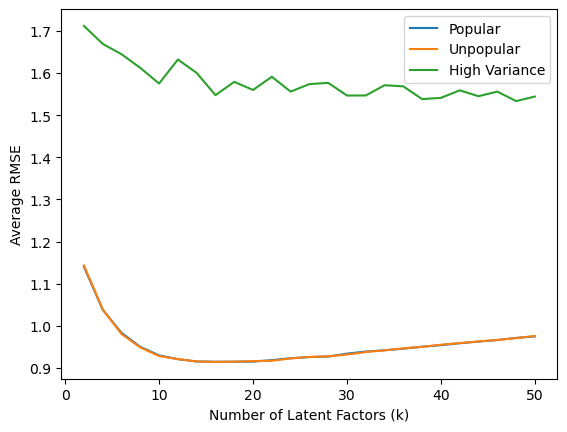

Minimum Average RMSE for Popular Subset: 0.9149651798336492
Minimum Average RMSE for Unpopular Subset: 0.9145124802185872
Minimum Average RMSE for High Variance Subset: 1.5334086565329106


In [173]:
# load the datasets
popular_df = popular_trim(df)
unpopular_df = unpopular_trim(df)
high_var_df = high_var_trim(df)

# convert the datasets to surprise format
popular_data = Dataset.load_from_df(popular_df[['userId', 'movieId', 'rating']], reader)
unpopular_data = Dataset.load_from_df(unpopular_df[['userId', 'movieId', 'rating']], reader)
high_var_data = Dataset.load_from_df(high_var_df[['userId', 'movieId', 'rating']], reader)
# define the range of k values
ks = range(2, 51, 2)

# define the NMF algorithm with default values


# define dictionaries to store the RMSE values for each subset
popular_rmse = {}
unpopular_rmse = {}
high_var_rmse = {}

# perform 10-fold cross-validation with NMF algorithm for each subset and each k
for k in ks:
    nmf=NMF(n_factors=k)
    popular_results = cross_validate(nmf, popular_data, measures=['RMSE'], cv=10, verbose=True)
    unpopular_results = cross_validate(nmf, unpopular_data, measures=['RMSE'], cv=10, verbose=True)
    high_var_results = cross_validate(nmf, high_var_data, measures=['RMSE'], cv=10, verbose=True)
    
    # store the average RMSE values for each subset and each k
    popular_rmse[k] = np.mean(popular_results['test_rmse'])
    unpopular_rmse[k] = np.mean(unpopular_results['test_rmse'])
    high_var_rmse[k] = np.mean(high_var_results['test_rmse'])

# plot the average RMSE against k for each subset
plt.plot(ks, list(popular_rmse.values()), label='Popular')
plt.plot(ks, list(unpopular_rmse.values()), label='Unpopular')
plt.plot(ks, list(high_var_rmse.values()), label='High Variance')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.legend()
plt.show()

# print the minimum average RMSE for each subset
print("Minimum Average RMSE for Popular Subset:", min(popular_rmse.values()))
print("Minimum Average RMSE for Unpopular Subset:", min(unpopular_rmse.values()))
print("Minimum Average RMSE for High Variance Subset:", min(high_var_rmse.values()))

### •Plot the ROC curves for the NMF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

Results for popular trimming'} with k=20


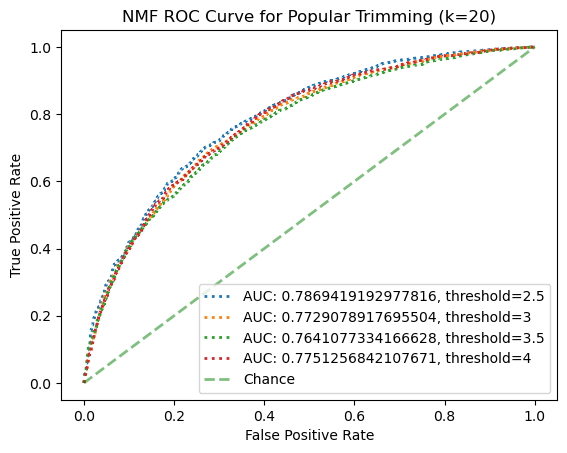

In [284]:
#popular trimmming

data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)
res = NMF(n_factors=20).fit(trainset).test(popular_trim(testset))
print("Results for popular trimming'} with k=20")
fig, ax = plt.subplots()
for item in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NMF ROC Curve for Popular Trimming (k=20)')
plt.legend(loc="lower right")
plt.show()

Results for unpopular trimming'} with k=20


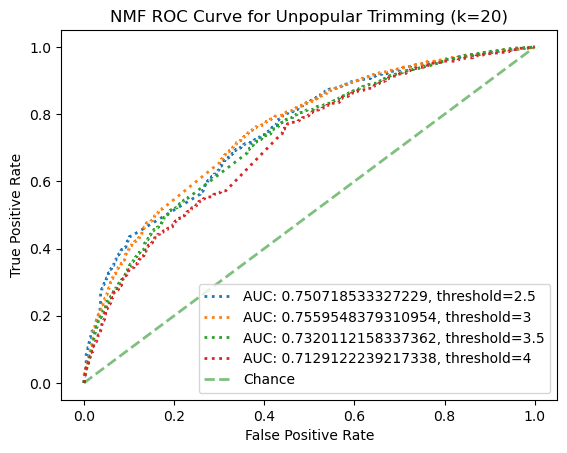

In [286]:
#Unpopular Trim
thresholds = [2.5, 3, 3.5, 4]

data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)
res = NMF(n_factors=20).fit(trainset).test(unpopular_trim(testset))
print("Results for unpopular trimming'} with k=20")
fig, ax = plt.subplots()
for item in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NMF ROC Curve for Unpopular Trimming (k=20)')
plt.legend(loc="lower right")
plt.show()

Results for high variance trimming'} with k=20


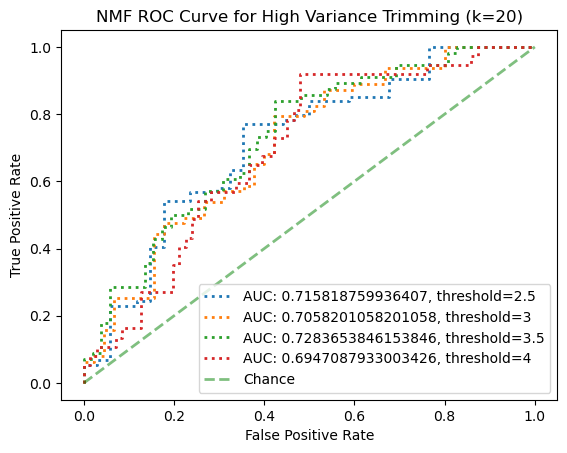

In [287]:
#High Variance Trim
thresholds = [2.5, 3, 3.5, 4]
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)
res = NMF(n_factors=20).fit(trainset).test(high_var_trim(testset))
print("Results for high variance trimming'} with k=20")
fig, ax = plt.subplots()
for item in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NMF ROC Curve for High Variance Trimming (k=20)')
plt.legend(loc="lower right")
plt.show()

# QUESTION 9: 
Interpreting the NMF model: Perform Non-negative matrix factorization on
the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent
factors interaction and V represents the movie-latent factors interaction (use k = 20). For each
column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the
top 10 movies belong to a particular or a small collection of genre? Is there a connection between
the latent factors and the movie genres?

### A: The top 10 movies in each column of movie-latent factor tend to belong to a small collection of genres. It is possible that there is a connection between the latent factors and the genres. 

In [399]:
V = NMF(n_factors=20, verbose=False).fit(train).qi
movie_df =df_movie = pd.read_csv('/Users/ryan/Downloads/Synthetic_Movie_Lens/movies.csv',names=['movieid','title','genres'], header=0)
for col in range(V.shape[1]):
  movie = V[:, col]
  movie = [(id, rank) for id, rank in enumerate(movie)]
  movie = sorted(movie, key=lambda x : x[1], reverse=True)[:10]
  print(f'column {col}')
  for id, _ in movie:
    print(movie_df['genres'][id])
  print('')

column 0
Drama
Comedy|Romance|Sci-Fi
Action|Adventure|Fantasy
Action|Adventure|Drama|Mystery|Thriller
Comedy|Drama
Comedy
Adventure|Animation|Children|Fantasy
Mystery|Sci-Fi|Thriller
Horror
Drama|Romance|Western

column 1
Comedy|Drama|Romance
Animation|Drama|Fantasy
Comedy|Drama|Romance
Drama|Romance
Action|Horror|Sci-Fi
Drama
Comedy|Sci-Fi
Comedy
Horror
Comedy

column 2
Crime|Drama|Mystery
Comedy|Drama|Romance
Action|Drama|Romance|War
Action|Horror|Sci-Fi|Thriller
Action|Crime|Drama|Thriller
Drama
Comedy|Romance|Sci-Fi
Comedy
Thriller
Action|Crime|Drama|Thriller

column 3
Crime|Horror|Thriller
Action|Comedy
Adventure|Comedy|War
Comedy|Drama
Documentary|War
Action|Adventure|Crime|Drama|Thriller|War
Comedy|Romance
Drama
Action|Adventure|Fantasy|Romance|IMAX
Drama

column 4
Action|Adventure|Comedy|Western
Adventure|Comedy|War
Action|Adventure|Fantasy
Crime|Drama
Horror|Mystery|Sci-Fi
Sci-Fi
Comedy|Romance
Drama|Thriller|War
Comedy
Documentary

column 5
Action|Thriller
Comedy|Musical
Adve

In [193]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)
# create the NMF model with k=20
nmf = NMF(n_factors=20)

# fit the model on the dataset
trainset = data.build_full_trainset()
nmf.fit(trainset)

# Get the V matrix from the trained model
V = nmf.qi


# get the top 3 genres of the top 10 movies for each latent factor based on their scores in the corresponding column of V
top_genres = {}
for i in range(V.shape[1]):
    top_movies_idx = np.argsort(V[:,i])[::-1][:10]
    top_movies = df_movie.iloc[top_movies_idx]
    genres = top_movies['genres'].str.split('|', expand=True).stack().value_counts()[:3].index.tolist()
    top_genres[i+1] = genres

# print out the top genres for each latent factor
print("Top genres for each latent factor:")
for k, v in top_genres.items():
    print("Latent factor {}: {}".format(k, ', '.join(v)))

Top genres for each latent factor:
Latent factor 1: Drama, Comedy, Crime
Latent factor 2: Drama, Comedy, Romance
Latent factor 3: Comedy, Action, Thriller
Latent factor 4: Comedy, Drama, Romance
Latent factor 5: Drama, Romance, Comedy
Latent factor 6: Drama, Comedy, War
Latent factor 7: Drama, Action, Thriller
Latent factor 8: Comedy, Romance, Drama
Latent factor 9: Action, Drama, Mystery
Latent factor 10: Drama, Action, Romance
Latent factor 11: Drama, Comedy, Sci-Fi
Latent factor 12: Comedy, Drama, Romance
Latent factor 13: Drama, Comedy, Thriller
Latent factor 14: Drama, Romance, Action
Latent factor 15: Drama, Comedy, Horror
Latent factor 16: Drama, Adventure, Western
Latent factor 17: Drama, Adventure, Romance
Latent factor 18: Drama, Comedy, Romance
Latent factor 19: Comedy, Drama, Romance
Latent factor 20: Comedy, Horror, Drama


# QUESTION 10: Designing the MF Collaborative Filter:

### A
Design a MF-based collaborative filter to predict the ratings of the movies in the original
dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of
latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE
and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the
average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
For solving this question, use the default value for the regularization parameter.

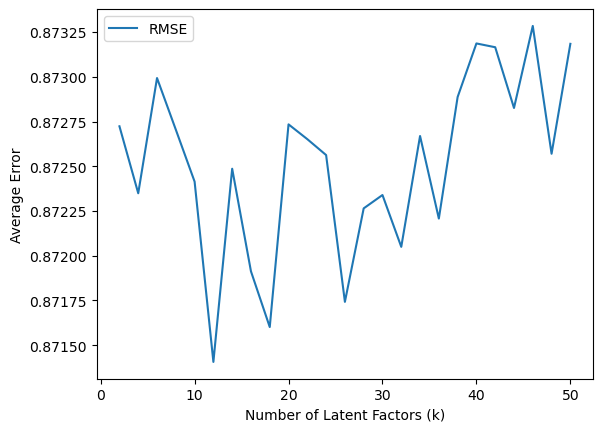

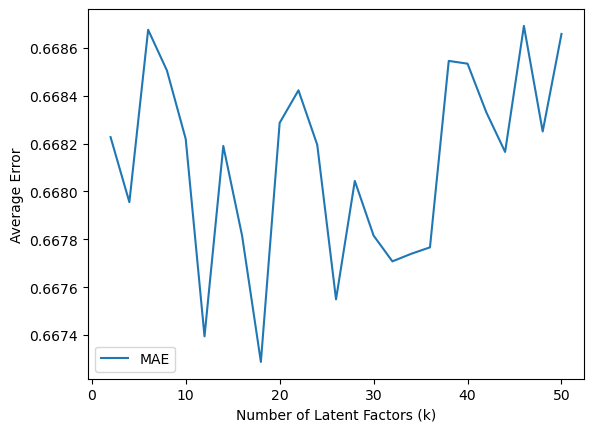

In [214]:
# load the dataset
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# define the range of k values to test
k_values = np.arange(2, 51, 2)


# perform 10-fold cross-validation with MF algorithm for different k values
rmse_scores = []
mae_scores = []
for k in k_values:
    results  = cross_validate(SVD(n_factors=k),
                         measures=['rmse','mae'],data = data, cv=10,  verbose=False)   
    rmse_scores.append(np.mean(results['test_rmse']))
    mae_scores.append(np.mean(results['test_mae']))

# plot the results
plt.plot(k_values, rmse_scores, label='RMSE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average Error')
plt.legend()
plt.show()

plt.plot(k_values, mae_scores, label='MAE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average Error')
plt.legend()
plt.show()


### B 
Use the plot from the previous part to find the optimal number of latent factors. Optimal
number of latent factors is the value of k that gives the minimum average RMSE or the
minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal
number of latent factors same as the number of movie genres?
### A: The optimal number of latent factors of RMSE for SVD is 12 and of MAE is 18 which is different from the number of movie genres.

In [215]:
print("Minimum average value of RMSE for SVD: %f, K Value: %d" % (min(rmse_scores),k_values[[i for i, x in enumerate(rmse_scores) if x == min(rmse_scores)][0]]))
print("Minimum average value of MAE for SVD: %f, K Value: %d" % (min(mae_scores),k_values[[i for i, x in enumerate(mae_scores) if x == min(mae_scores)][0]]))


Minimum average value of RMSE for SVD: 0.871406, K Value: 12
Minimum average value of MAE for SVD: 0.667288, K Value: 18


### C 
Performance on dataset subsets: For each of Popular, Unpopular and High-Variance subsets
-
– Design a MF collaborative filter for each trimmed subset and evaluate its performance
using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step
sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE
across all 10 folds.
– Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

Evaluating Popular subset...


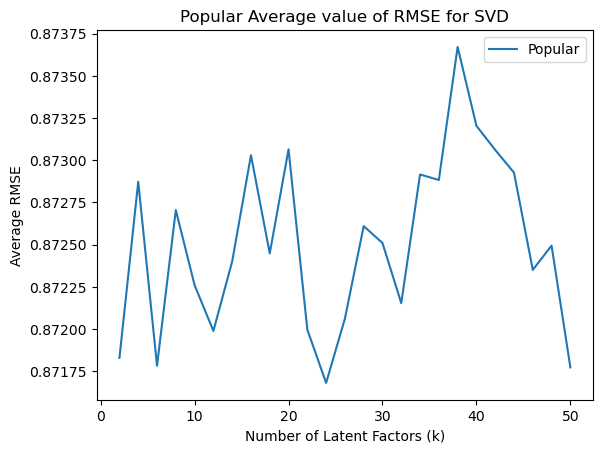

Evaluating Unpopular subset...


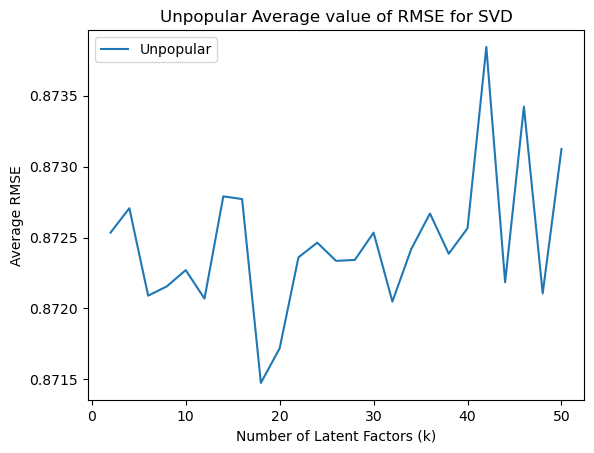

Evaluating High-Variance subset...


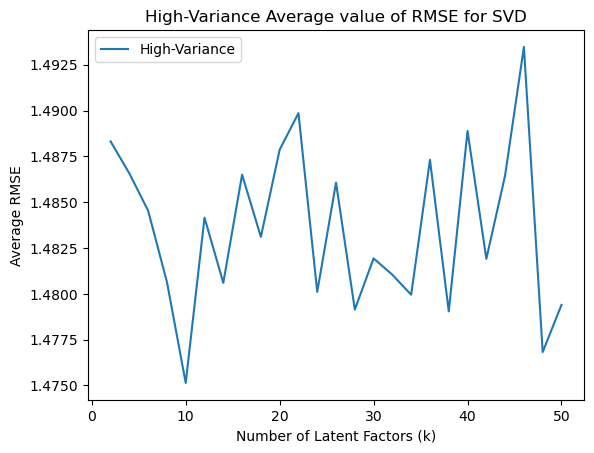

In [206]:
# define the range of k values to test
k_values = np.arange(2, 51, 2)

# evaluate performance for each subset
for subset, subset_name in zip([popular_trim, unpopular_trim, high_var_trim], ['Popular', 'Unpopular', 'High-Variance']):
    print(f"Evaluating {subset_name} subset...")
    subset_data = Dataset.load_from_df(subset(df)[['userId', 'movieId', 'rating']], reader)
    rmse_scores = []
    for k in k_values:
        algo = SVD(n_factors=k)
        results = cross_validate(algo, subset_data, measures=['RMSE'], cv=10, verbose=False)
        rmse_scores.append(np.mean(results['test_rmse']))

    # plot the results
    plt.plot(k_values, rmse_scores, label=subset_name)

    # plot the figure
    plt.title(subset_name +' Average value of RMSE for SVD')
    plt.xlabel('Number of Latent Factors (k)')
    plt.ylabel('Average RMSE')
    plt.legend()
    plt.show()

### •Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

Results for popular trimming with k=24


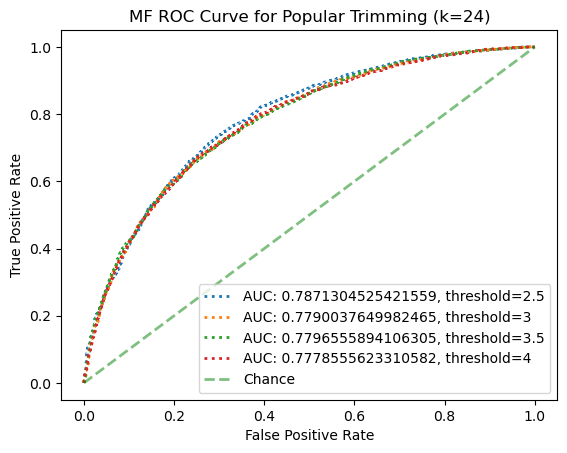

In [292]:
def popular_trim(testset: List[Tuple[int, int, float]]) -> List[Tuple[int, int, float]]:
    # Count the number of ratings for each movie
    movie_ratings = defaultdict(int)
    for (uid, iid, rating) in testset:
        movie_ratings[iid] += 1

    # Identify popular movies
    popular_movies = set(iid for iid, count in movie_ratings.items() if count > 2)

    # Filter out unpopular movies from the test set
    return [t for t in testset if len(t) == 3 and t[1] in popular_movies]
threshold_vals = [2.5, 3, 3.5, 4]
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)
res = SVD(n_factors=24).fit(trainset).test(popular_trim(testset))
print("Results for popular trimming with k=24")
fig, ax = plt.subplots()
for threshold_val in threshold_vals:
    thresholded_out = []
    for row in res:
        if row.r_ui > threshold_val:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(threshold_val))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MF ROC Curve for Popular Trimming (k=24)')
plt.legend(loc="lower right")
plt.show()

Results for unpopular trimming'} with k=18


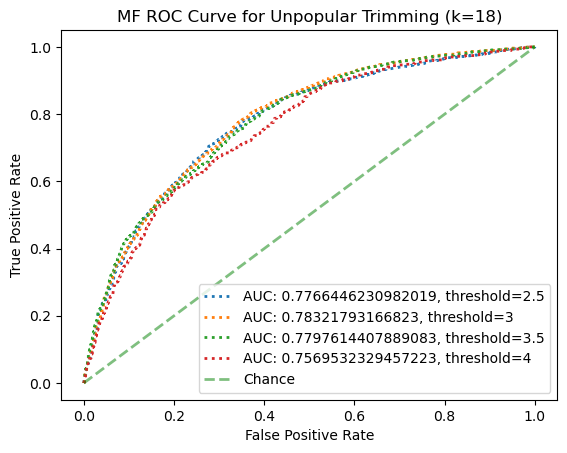

In [293]:
#Unpopular Trim
thresholds = [2.5, 3, 3.5, 4]
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)
res = SVD(n_factors=18).fit(trainset).test(unpopular_trim(testset))
print("Results for unpopular trimming'} with k=18")
fig, ax = plt.subplots()
for item in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MF ROC Curve for Unpopular Trimming (k=18)')
plt.legend(loc="lower right")
plt.show()

Results for high variance trimming'} with k=10


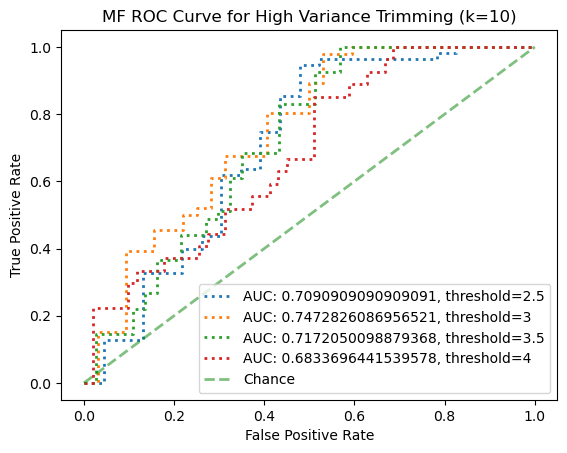

In [295]:
#High Variance Trim
thresholds = [2.5, 3, 3.5, 4]
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)
res = SVD(n_factors=10).fit(trainset).test(high_var_trim(testset))
print("Results for high variance trimming'} with k=10")
fig, ax = plt.subplots()
for item in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MF ROC Curve for High Variance Trimming (k=10)')
plt.legend(loc="lower right")
plt.show()

# QUESTION 11: 
Designing a Na ̈ıve Collaborative Filter:
•Design a naive collaborative filter to predict the ratings of the movies in the original dataset
and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by
averaging the RMSE across all 10 folds. Report the average RMSE.
•Performance on dataset subsets: For each of Popular, Unpopular and High-Variance test
subsets -
– Design a naive collaborative filter for each trimmed set and evaluate its performance using
10-fold cross validation.
– Compute the average RMSE by averaging the RMSE across all 10 folds. Report the
average RMSE.

In [343]:
from surprise.model_selection import KFold
def popular_trimming(df):
  df = pd.DataFrame(df, columns=['userId', 'movieId', 'rating'])
  filter = df['movieId'].value_counts() > 2
  filter_id = filter[filter].index.to_list()
  return df[df.movieId.isin(filter_id)].to_records(index=False)

def unpopular_trimming(df):
  df = pd.DataFrame(df, columns=['userId', 'movieId', 'rating'])
  filter = df['movieId'].value_counts() <= 2
  filter_id = filter[filter].index.to_list()
  return df[df.movieId.isin(filter_id)].to_records(index=False)

def high_variance_trimming(df):
  df = pd.DataFrame(df, columns=['userId', 'movieId', 'rating'])
  filter = df['movieId'].value_counts() >= 5
  filter_id = filter[filter].index.to_list()
  movie_variances = df.groupby('movieId')['rating'].var(ddof=0)
  low_var = movie_variances[movie_variances < 2].index.to_list()
  filter_id = [id for id in filter_id if id not in low_var]
  return df[df.movieId.isin(filter_id)].to_records(index=False)
def no_trimming(df):
  return df
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

rating_record = defaultdict(list)
for user, _, rating, _ in data.raw_ratings:
  rating_record[user].append(rating)
rating = {}
for user, ratings in rating_record.items():
  rating[user] = np.mean(ratings)

for trimming in [no_trimming, popular_trimming, unpopular_trimming, high_variance_trimming]:
  rmse = []
  for _, test in KFold(10).split(data):
    test = trimming(test)
    pred = [rating[user] for user, _, _ in test]
    true = [r for _, _, r in test]
    rmse.append(np.sqrt(metrics.mean_squared_error(pred, true)))
  rmse = np.mean(rmse)
  print(f'Naive Collaborative Filter with {trimming.__name__} {rmse=}')

Naive Collaborative Filter with no_trimming rmse=0.9346752906105265
Naive Collaborative Filter with popular_trimming rmse=0.9243283649127395
Naive Collaborative Filter with unpopular_trimming rmse=0.9583897415046927
Naive Collaborative Filter with high_variance_trimming rmse=1.4319058156339024


# QUESTION 12: 
Comparing the most performant models across architecture: Plot the
best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters
in the same figure. Use the figure to compare the performance of the filters in predicting the ratings
of the movies.

Results for No Trimming with k=20
Computing the pearson similarity matrix...
Done computing similarity matrix.


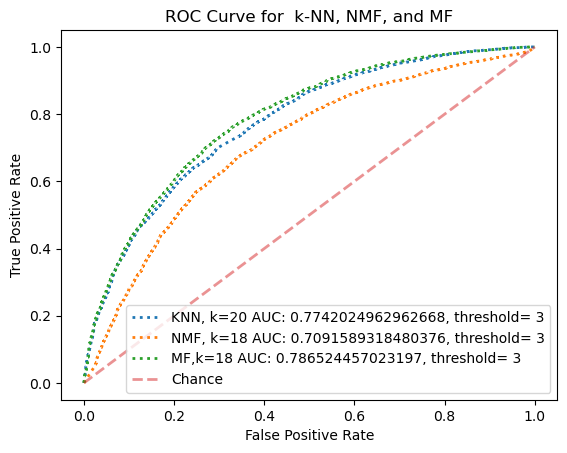

In [356]:
# Load the data

reader = Reader(rating_scale=(0.5, 5.0))


# Define the k-NN collaborative filtering algorithm and train the models

knn=KNNWithMeans(k=20, sim_options={'name': 'pearson', 'user_based': True})
nmf=NMF(n_factors=18,biased=True)
mf=SVD(n_factors=18, biased=True)

algo = [(knn, "KNN, k=20"),(nmf, "NMF, k=18"),(mf, "MF,k=18")]
print("Results for No Trimming with k=20")
fig, ax = plt.subplots()
for i, algo_name in algo:
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    trainset, testset = train_test_split(data, test_size=0.1)
    res = i.fit(trainset).test(testset)
    thresholded_out = []
    for row in res:
        if row.r_ui > 3:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label= algo_name +" AUC: "+str(auc(fpr,tpr))+', threshold= 3')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Chance', alpha=.5)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for  k-NN, NMF, and MF')
plt.legend(loc="lower right")
plt.show()

# QUESTION 13: 
Understanding Precision and Recall in the context of Recommender
Systems: Precision and Recall are defined by the mathematical expressions given by equations 12
and 13 respectively. Please explain the meaning of precision and recall in your own words.

### A:
Precision is the proportion of recommended items that are relevant to the user's interests. In other words, it is the ratio of the number of correctly recommended items to the total number of recommended items.

Recall is the proportion of relevant items that are recommended by the system. In other words, it is the ratio of the number of correctly recommended items to the total number of relevant items. 


# QUESTION 14: 
Comparing the precision-recall metrics for the different models:

•For each of the three architectures:
– Plot average precision (Y-axis) against t (X-axis) for the ranking obtained using the model’s
predictions.
### – Plot the average recall (Y-axis) against t (X-axis) and plot the average precision (Y-axis) against average recall (X-axis). – Use the best k found in the previous parts and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.


Hints:
•Use threshold = 3 for obtaining the set G
•Use 10-fold cross-validation to obtain the average precision and recall values for each value of t. To be specific, compute precision
and recall for each user using equations 12 and 13 and then average across all the users in the dataset to obtain the precision and
recall for this fold. Now repeat the above procedure to compute the precision and recall for all the folds and then take the average
across all the 10-folds to obtain the average precision and average recall value for this value of t.
•If |G| = 0 for some user in the validation set, then drop this user
•If some user in the validation set has rated less than t items, then drop this user.

100%|███████████████████████████████████████████████| 25/25 [22:51<00:00, 54.85s/it]


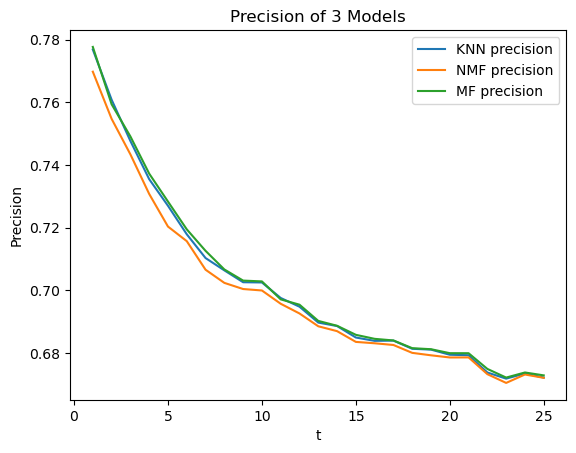

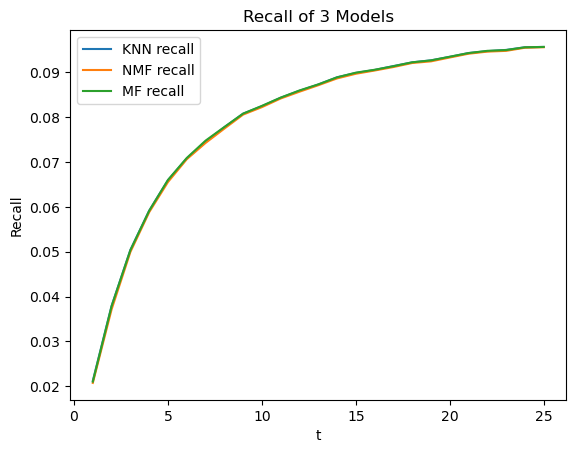

In [382]:
#Plot Average Precision and Recall
from tqdm import tqdm
def get_metrics(pred, G, t, ur):
    S = {}
    for p in pred:
        if p.uid in S.keys():
            continue
        cur_user = set()
        for k in pred:
            if p.uid == k.uid:
                cur_user.add((k.iid, k.est))
        cur_user = sorted(list(cur_user), key=lambda x: x[1], reverse=True)[:t]
        S[p.uid] = [c[0] for c in cur_user]
 
    precision, recall = [], []
    for i in S:
        g = G[i]
        s = S[i]
        if len(g) == 0 or len(ur[i]) < t: continue
        intersection = list(set(g) & set(s))
        precision.append(len(intersection) / float(len(s)))
        recall.append(len(intersection) / float(len(g)))
    return np.mean(precision), np.mean(recall)
t_list = list(range(1, 26))
kf = KFold(n_splits=10)

G = {}
full_train = data.build_full_trainset()
for u in full_train.ur:
    ratings = full_train.ur[u]
    G[full_train.to_raw_uid(u)] = [full_train.to_raw_iid(i[0]) for i in ratings if i[1] > 3]

res_list = []
for t in tqdm(t_list):
    metrics_matrix = np.zeros((6, 10))
    for idx, (train, test) in enumerate(kf.split(data)):
        knn_pred = KNNWithMeans(k=20, sim_options={'name':'pearson'}, verbose=False).fit(train).test(test)
        nmf_pred = NMF(n_factors=20, verbose=False).fit(train).test(test)
        mf_pred = NMF(n_factors=2, biased=True, verbose=False).fit(train).test(test)
        
        metrics_matrix[0][idx], metrics_matrix[3][idx] = get_metrics(knn_pred, G, t, full_train.ur)
        metrics_matrix[1][idx], metrics_matrix[4][idx] = get_metrics(nmf_pred, G, t, full_train.ur)
        metrics_matrix[2][idx], metrics_matrix[5][idx] = get_metrics(mf_pred, G, t, full_train.ur)

    res_list.append(list(np.mean(metrics_matrix, axis=1)))
res_list = np.array(res_list)
plt.plot(t_list, res_list[:, 0], label='KNN precision')
plt.plot(t_list, res_list[:, 1], label='NMF precision')
plt.plot(t_list, res_list[:, 2], label='MF precision')
plt.legend()
plt.title("Precision of 3 Models")
plt.xlabel("t")
plt.ylabel("Precision")
plt.show()

plt.plot(t_list, res_list[:, 3], label='KNN recall')
plt.plot(t_list, res_list[:, 4], label='NMF recall')
plt.plot(t_list, res_list[:, 5], label='MF recall')
plt.legend()
plt.title("Recall of 3 Models")
plt.xlabel("t")
plt.ylabel("Recall")
plt.show()

### •Plot the best precision-recall curves obtained for the three models (k-NN, NMF, MF) in the same figure. Use this figure to compare the relevance of the recommendation list generated using k-NN, NMF, and MF with bias predictions.


In [ ]:
from sklearn import metrics

# Load data and split into train and test sets
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
train, test = train_test_split(data, test_size=0.1)

# Fit models and make predictions on test set
knn_pred = KNNWithMeans(k=20, sim_options={'name':'pearson'}, verbose=False).fit(train).test(test)
nmf_pred = NMF(n_factors=20, verbose=False).fit(train).test(test)
mf_pred = NMF(n_factors=2, biased=True, verbose=False).fit(train).test(test)

# Define a list of (predictions, name) tuples for the three models
pred_list = [(knn_pred, "KNN"), (nmf_pred, "NMF"), (mf_pred, "MF")]

# Plot precision-recall curves for the three models
for pred, name in pred_list:
    y_true = [1 if i.r_ui >= 3 else 0 for i in test]
    score = [i.est for i in pred]
    precision, recall, _ = metrics.precision_recall_curve(y_true, score, pos_label=1)
    plt.plot(recall, precision, label=name)

plt.legend()
plt.title('Precision-recall curve for KNN, NMF and MF')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


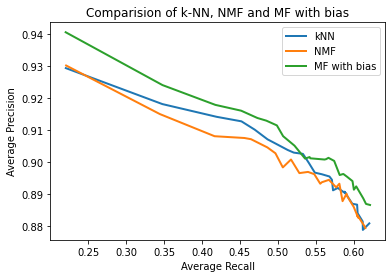